## Conditional Laplace INLA

Let's first just set up our environment. The dataset is the one from Figure 2 from Berry 2013.

In [1]:
import berrylib.util as util

util.setup_nb()

import pickle
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np

import inlaw
import berrylib.mcmc as mcmc

y = np.array(
    [
        [0.0, 1.0, 3.0, 3.0],
        [0.0, 1.0, 4.0, 5.0],
        [0.0, 1.0, 6.0, 6.0],
        [0.0, 1.0, 6.0, 7.0],
        [0.0, 1.0, 7.0, 8.0],
        [0.0, 1.0, 9.0, 10.0],
    ]
)
n = np.array(
    [
        [10, 10, 10, 10],
        [15, 15, 15, 15],
        [20, 20, 20, 20],
        [20, 20, 25, 25],
        [20, 20, 30, 30],
        [20, 20, 35, 35],
    ]
)
data = np.stack((y[-1:], n[-1:]), axis=-1)

/Users/tbent/.mambaforge/envs/imprint2/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/tbent/.mambaforge/envs/imprint2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


And load up some MCMC results, both for the full problem and conditional on various values of $\sigma^2$.

In [20]:
sig2_n = 15
sig2_rule = inlaw.quad.log_gauss_rule(N=sig2_n, a=1e-6, b=1e3)

load = True
if load:
    with open("conditional_mcmc.pkl", "rb") as f:
        mcmc_results, mcmc_arm_marg = pickle.load(f)
else:
    mcmc_results = []
    for sig_idx in range(fi.sigma2_n):
        mcmc_results.append(
            mcmc.mcmc_berry(
                np.stack((y[-1:], n[-1:]), axis=-1),
                n_samples=200000,
                sigma2_val=sig2_rule.pts[sig_idx],
            )
        )
    mcmc_arm_marg = mcmc.mcmc_berry(
        np.stack((y[-1:], n[-1:]), axis=-1),
        n_samples=200000,
    )
    with open("conditional_mcmc.pkl", "wb") as f:
        pickle.dump((mcmc_results, mcmc_arm_marg), f)


Then we calculate the hyperparameter posteriors in the variable `post`. 

In [10]:
fl = inlaw.FullLaplace(inlaw.berry_model.berry_model(4), "sig2", np.zeros((4, 2)))
p_pinned = dict(sig2=sig2_rule.pts, theta=None)
logpost, x_max, hess, iters = fl(p_pinned, data)
post = inlaw.inla.exp_and_normalize(logpost, sig2_rule.wts, axis=1)

## Choosing points for INLA

One of the difficult issues with the more accurate versions of INLA is that we need to choose a grid of points at which to evaluate the latent variable marginals.

Ideally, this choice is automatic.

### Gauss-Hermite quadrature works nicely for integrating well-behaved densities from $-\infty$ to $\infty$

**Gauss-Hermite quadrature**: is perfect for this use case since it's designed to integrate functions over the entire real domain that look like Gaussians multiplied by well-behaved polynomial-ish functions:

$$
\int_{-\infty}^{\infty} f(x) e^{-x^2} dx
$$

**Scaling Gauss-Hermite quadrature**: 
One way of thinking about this is that GH quadrature is good at integrating the unit normal distribution. Via change of variables, we can transform other normal distributions into the unit and integrate them with GH quadrature too.  

The figure below demonstrates that this results in much faster convergence and more accurate integrals. If the scale = 2.0 (the true standard deviation), then convergence is fastest. But scales that are slightly different are okay too. If the scale is very different, then convergence is quite slow!

Since we know the hessian at the mode, we can give GH quadrature a good guess of the standard deviation and get nice integrals.

In [6]:
def f(x):
    return np.sin(x) ** 2 * np.exp(-((x / 2) ** 2))


def gauss_I(n, scale=1.0):
    gr = util.gauss_rule(n, -10 * scale, 10 * scale)
    gp, gw = gr.pts, gr.wts
    y = f(gp)
    return np.sum(y * gw)


In [7]:
def herm_I(n, scale=1.0):
    hr = inlaw.quad.gauss_herm_rule(n, center=0, scale=scale)
    return np.sum(hr.wts * f(hr.pts))


The accuracy is best when the scale matches the standard deviation of the density, but it still works well even if the standard deviation is somewhat off.

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_75472/2288328674.py:15: RuntimeWarning: divide by zero encountered in log10
  ns, np.log10(herr[i]), label=f"Hermite scale={scales[i]:.2f}", linewidth=3.0


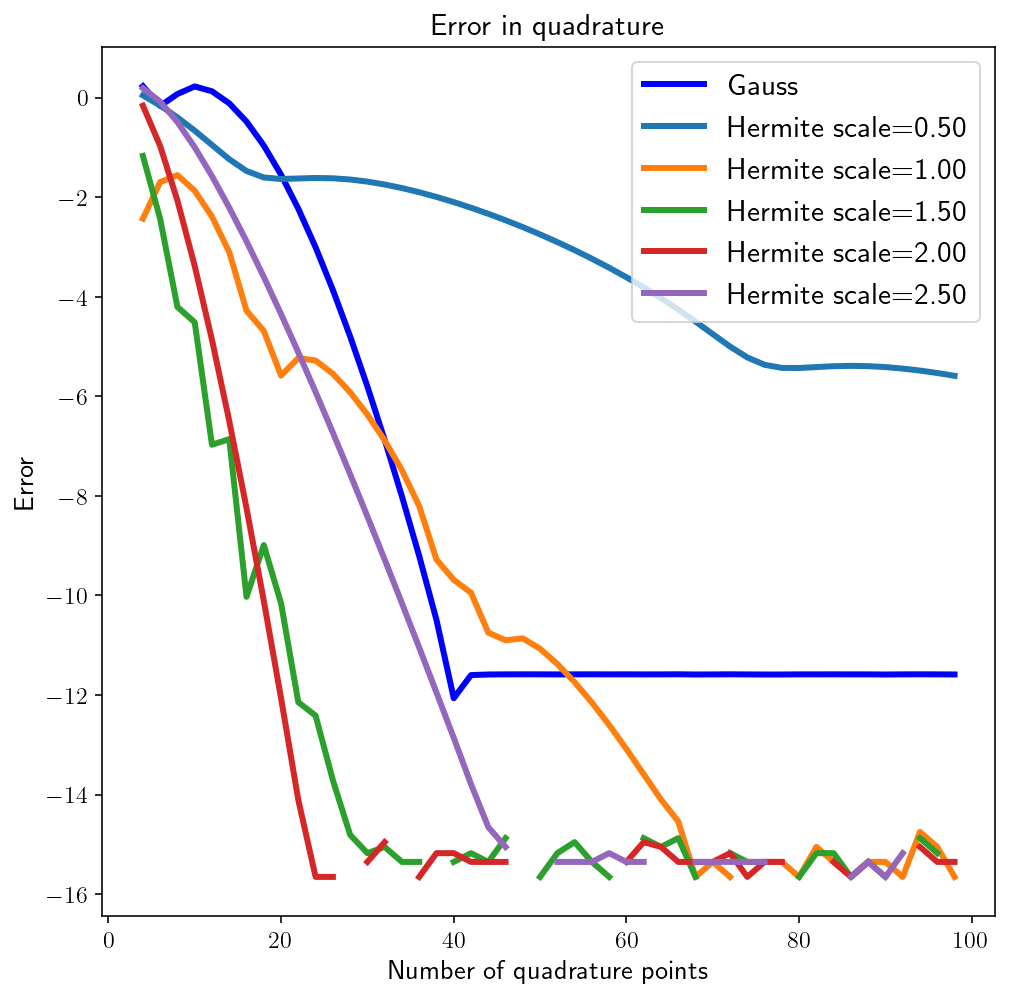

In [8]:
exact = herm_I(100, scale=2.0)
gerr = []
scales = np.array([0.5, 1.0, 1.5, 2.0, 2.5])
herr = [[] for i in range(len(scales))]
ns = range(4, 100, 2)
for n in ns:
    gerr.append(np.abs(gauss_I(n, scale=1.0) - exact))
    for i, scale in enumerate(scales):
        herr[i].append(np.abs(herm_I(n, scale=scale) - exact))
# Plot comparing gauss quadrature and hermite quadrature
plt.figure(figsize=(8, 8))
plt.plot(ns, np.log10(gerr), "b-", label="Gauss", linewidth=3.0)
for i in range(len(herr)):
    plt.plot(
        ns, np.log10(herr[i]), label=f"Hermite scale={scales[i]:.2f}", linewidth=3.0
    )
plt.legend()
plt.xlabel("Number of quadrature points")
plt.ylabel("Error")
plt.title("Error in quadrature")
plt.show()


## Running conditional INLA with Gauss-Hermite

In this first section, we're going to compute the grid of points separately for each value of the hyperparameter $\sigma^2$.

In [11]:
hg_rule = inlaw.quad.gauss_herm_rule(25)

arm_idx = 0
cond_inla_f = inlaw.inla.build_conditional_inla(fl.log_joint_single, fl.spec)

hg_pts, hg_wts = hg_rule.pts, hg_rule.wts
mu_arm = x_max
sd_arm = np.sqrt(-np.diagonal(np.linalg.inv(hess), axis1=2, axis2=3))
cx = mu_arm[None, ..., arm_idx] + sd_arm[None, ..., arm_idx] * hg_pts[:, None, None]
lp = cond_inla_f(x_max, p_pinned, data, hess, cx, arm_idx)
wts = sd_arm[None, ..., arm_idx] * hg_wts[:, None, None]
arm_marg = inlaw.inla.exp_and_normalize(lp, wts, axis=0)


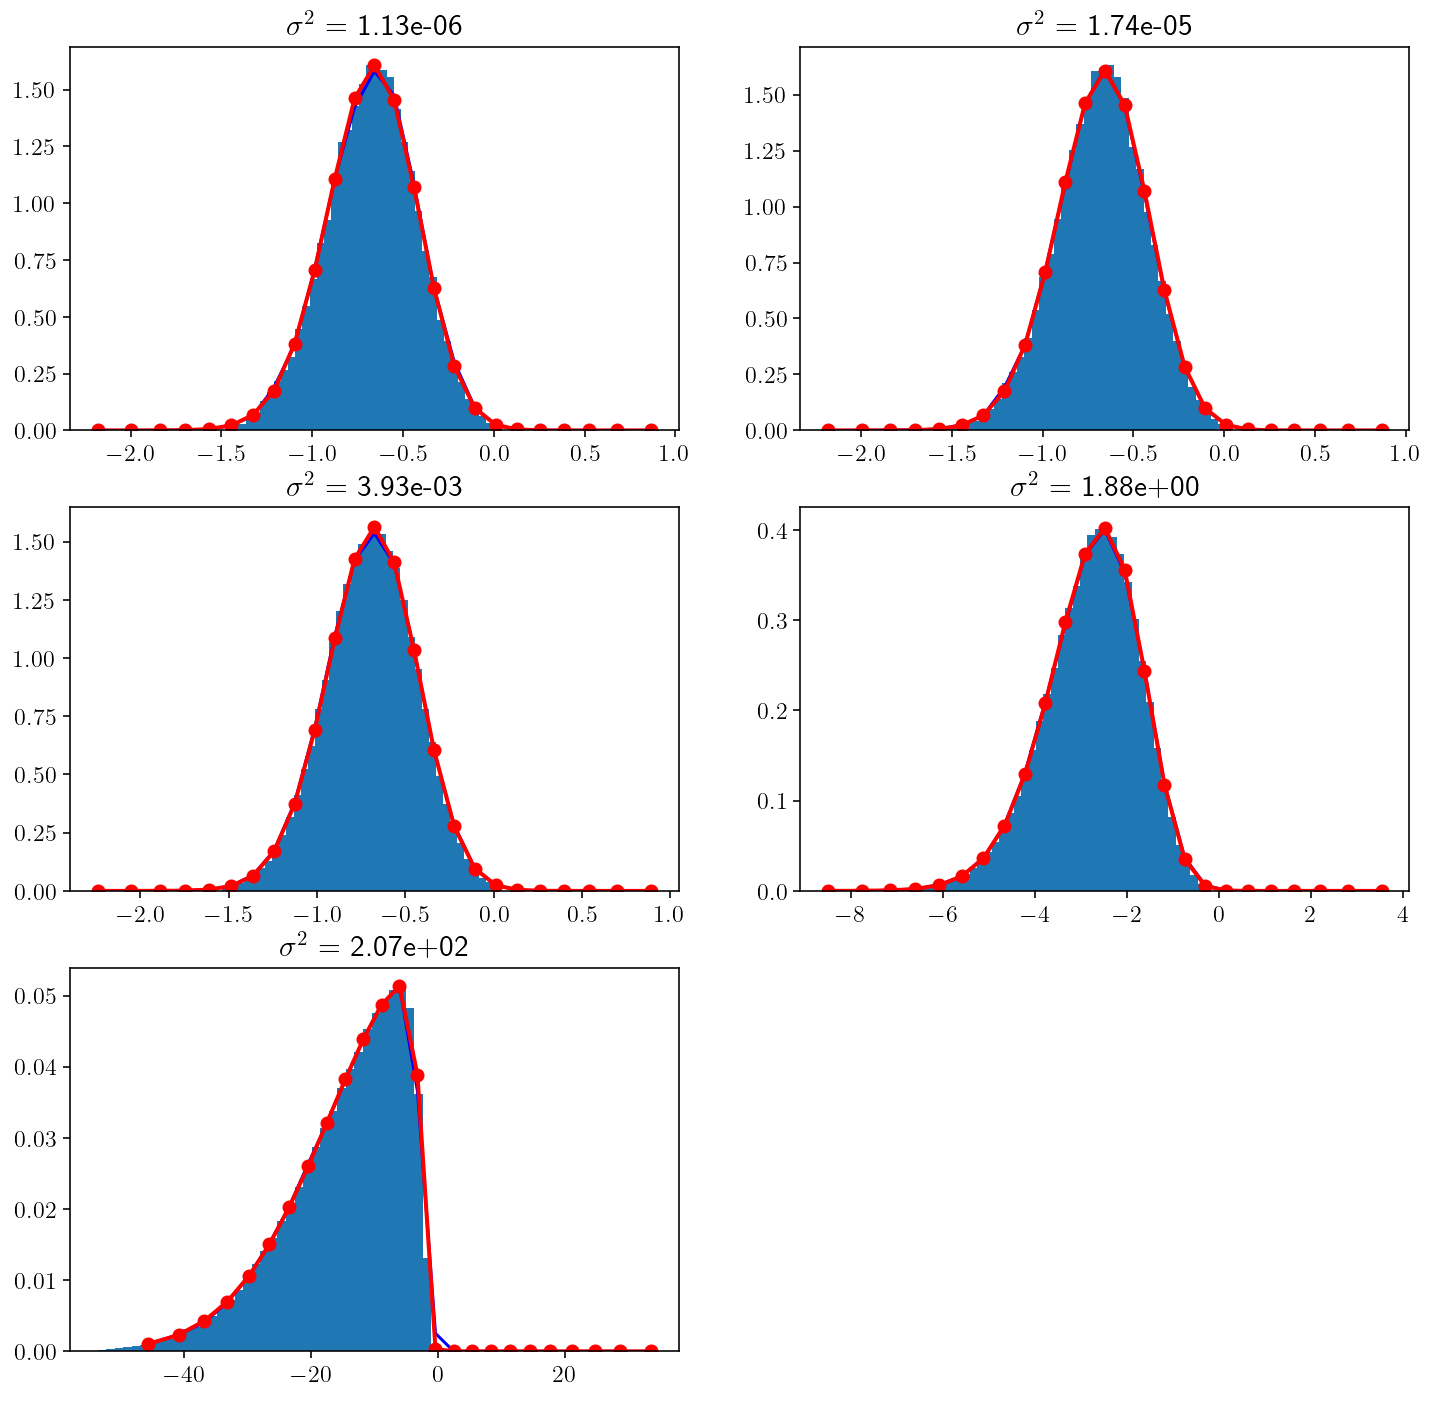

In [21]:
plt.figure(figsize=(12, 12))
for j, sig_idx in enumerate(range(sig2_n)[::3]):
    mcmc_arm = mcmc_results[sig_idx]["x"][0]["theta"][0, :, arm_idx]
    mcmc_p_ti_g_y = mcmc.calc_pdf(mcmc_arm, cx[:, 0, sig_idx], wts[:, 0, sig_idx])

    plt.subplot(3, 2, 1 + j)
    plt.title(f"$\sigma^2$ = {sig2_rule.pts[sig_idx]:5.2e}")
    plt.plot(cx[:, 0, sig_idx], mcmc_p_ti_g_y, "b-")
    plt.plot(cx[:, 0, sig_idx], arm_marg[:, 0, sig_idx], "r-o", linewidth=2.0)
    window = np.quantile(mcmc_arm, [0.001, 0.999])
    plt.hist(mcmc_arm, bins=np.linspace(*window, 40), density=True)
plt.show()


In [22]:
x_sigma2 = -np.diagonal(np.linalg.inv(hess), axis1=2, axis2=3)
mu_arm = np.sum(post[..., None] * x_max * sig2_rule.wts[None, :, None], axis=1)
var_arm = np.sum(
    post[..., None]
    * ((x_max - mu_arm[:, None, :]) ** 2 + x_sigma2)
    * sig2_rule.wts[None, :, None],
    axis=1,
)
mu_arm, var_arm
sd_arm = np.sqrt(var_arm)


In [29]:
hg_rule = inlaw.quad.gauss_herm_rule(70)
hg_pts, hg_wts = hg_rule.pts, hg_rule.wts
cx = np.tile(
    mu_arm[:, None, arm_idx] + sd_arm[:, None, arm_idx] * hg_pts[:, None, None],
    (1, 1, sig2_n),
)
lp = cond_inla_f(x_max, p_pinned, data, hess, cx, arm_idx)
wts = np.tile(sd_arm[:, None, arm_idx] * hg_wts[:, None, None], (1, 1, sig2_n))
arm_marg = inlaw.inla.exp_and_normalize(lp, wts, axis=0)


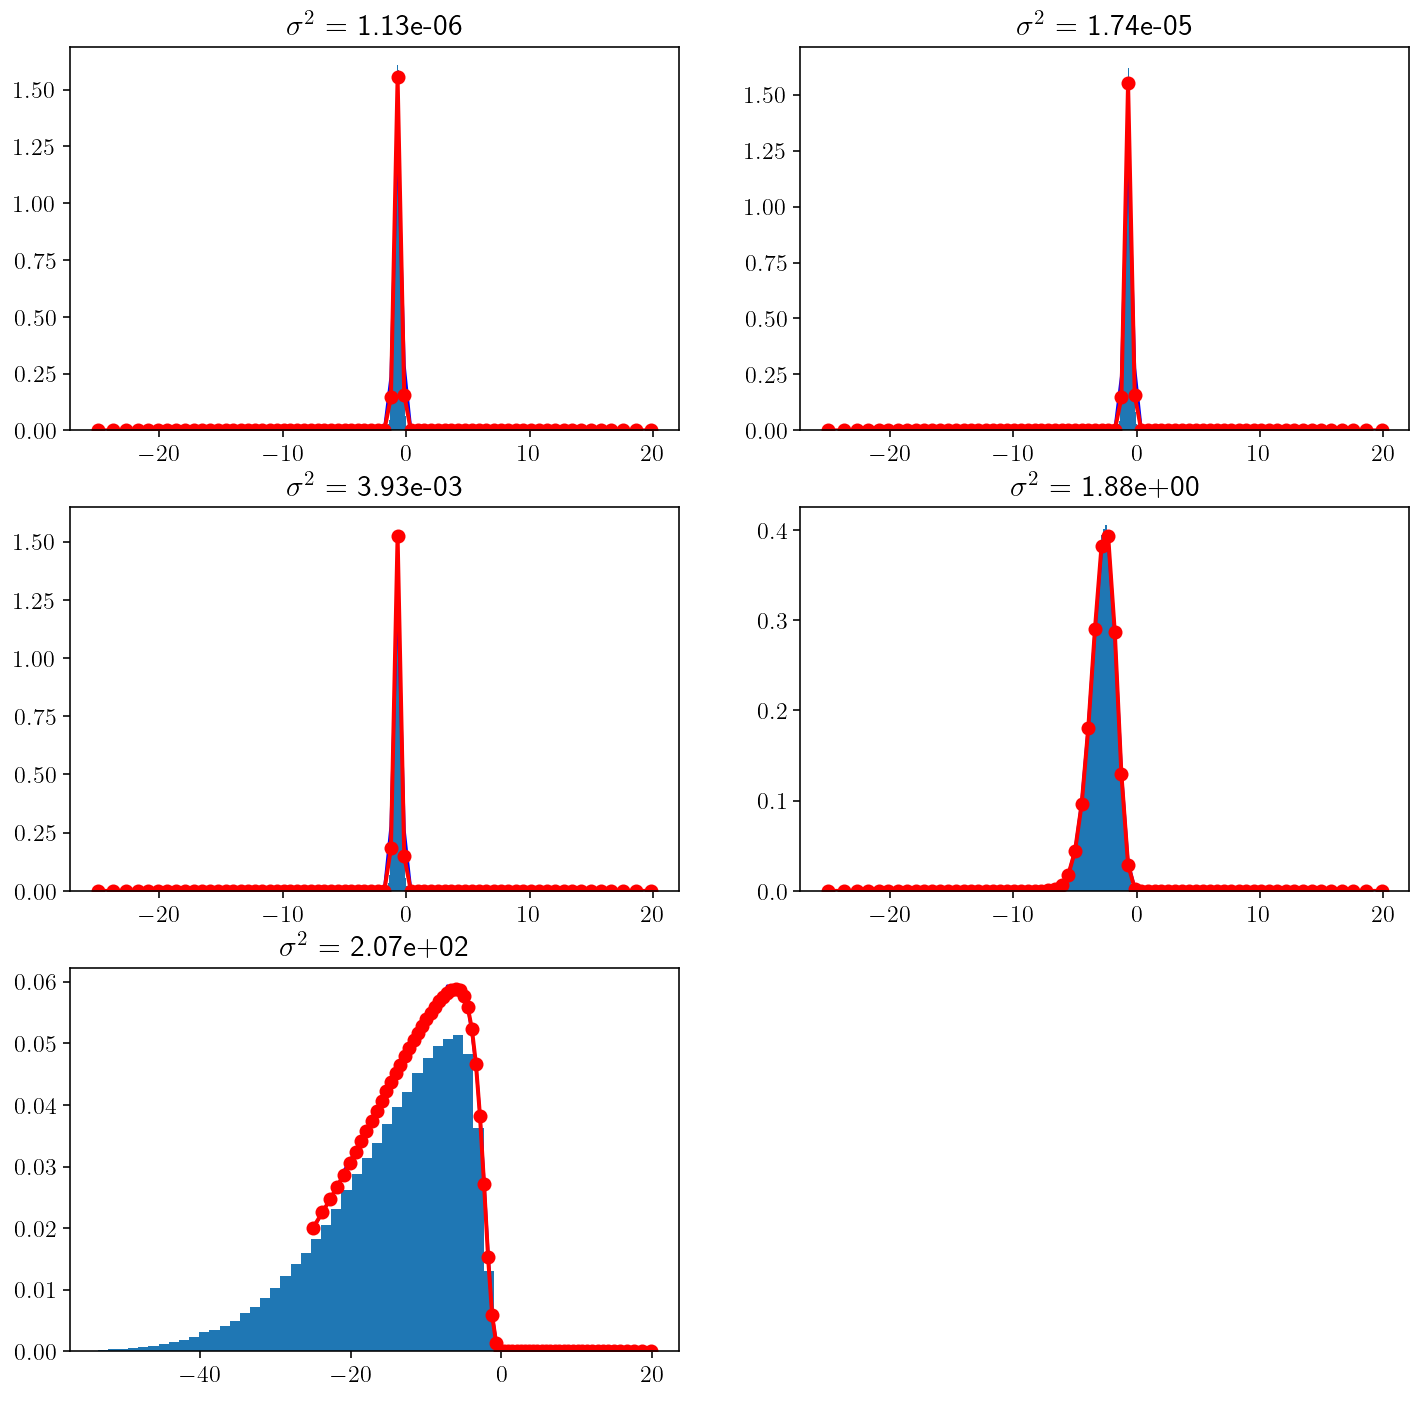

In [30]:
plt.figure(figsize=(12, 12))
for j, sig_idx in enumerate(range(sig2_n)[::3]):
    mcmc_arm = mcmc_results[sig_idx]["x"][0]["theta"][0, :, arm_idx]
    mcmc_p_ti_g_y = mcmc.calc_pdf(mcmc_arm, cx[:, 0, sig_idx], wts[:, 0, sig_idx])

    plt.subplot(3, 2, 1 + j)
    plt.title(f"$\sigma^2$ = {sig2_rule.pts[sig_idx]:5.2e}")
    plt.plot(cx[:, 0, sig_idx], mcmc_p_ti_g_y, "b-")
    plt.plot(cx[:, 0, sig_idx], arm_marg[:, 0, sig_idx], "r-o", linewidth=2.0)
    window = np.quantile(mcmc_arm, [0.001, 0.999])
    plt.hist(mcmc_arm, bins=np.linspace(*window, 40), density=True)
plt.show()


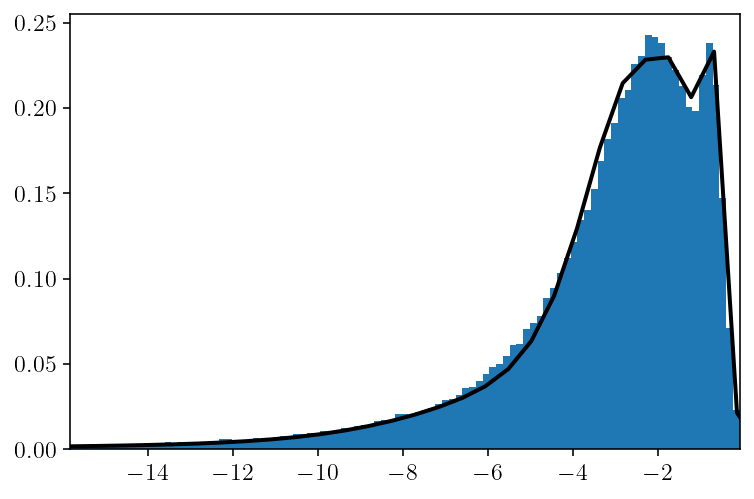

In [31]:
mcmc_arm = mcmc_arm_marg["x"][0]["theta"][0, :, arm_idx]
int_arm_marg = np.sum(arm_marg * post[None] * sig2_rule.wts[None, None], axis=2)
window = np.quantile(mcmc_arm, [0.01, 0.999])
plt.hist(mcmc_arm, bins=np.linspace(*window, 100), density=True)
plt.plot(cx[:, 0, 0], int_arm_marg, "k-", linewidth=2.0)
plt.xlim(window)
plt.show()


## adaptive quadrature rule.

this will get far enough out from the mode, but is more complicated and possibly slower. not sure!

In [8]:
mu_arm = x_max
sd_arm = np.sqrt(-np.diagonal(np.linalg.inv(hess), axis1=2, axis2=3))


In [9]:
def eval_cx(cx):
    return cond_inla_f(x_max, p_pinned, data, hess, cx, arm_idx)


cx_all = [mu_arm[None, ..., arm_idx]]
arm_marg_all = [eval_cx(mu_arm[None, ..., arm_idx])]
for i in range(8):
    a = i
    b = i + 1

    domain = np.linspace(a, b, 5)[1:]
    cx = mu_arm[None, ..., arm_idx] + sd_arm[None, ..., arm_idx] * domain[:, None, None]
    lp = eval_cx(cx)

    cx_all.append(cx)
    arm_marg_all.append(lp)


In [10]:
cx_all = np.concatenate(cx_all, axis=0)
arm_marg_all = np.concatenate(arm_marg_all, axis=0)


In [11]:
order = np.argsort(cx_all[:, 0, 0])
cx_all = cx_all[order]
arm_marg_all = arm_marg_all[order]
a = cx_all[0]
b = cx_all[-1]
wts = np.tile(((b - a) / cx_all.shape[0])[None], (cx_all.shape[0], 1, 1))
arm_marg = inlaw.inla.exp_and_normalize(arm_marg_all, wts, axis=0)


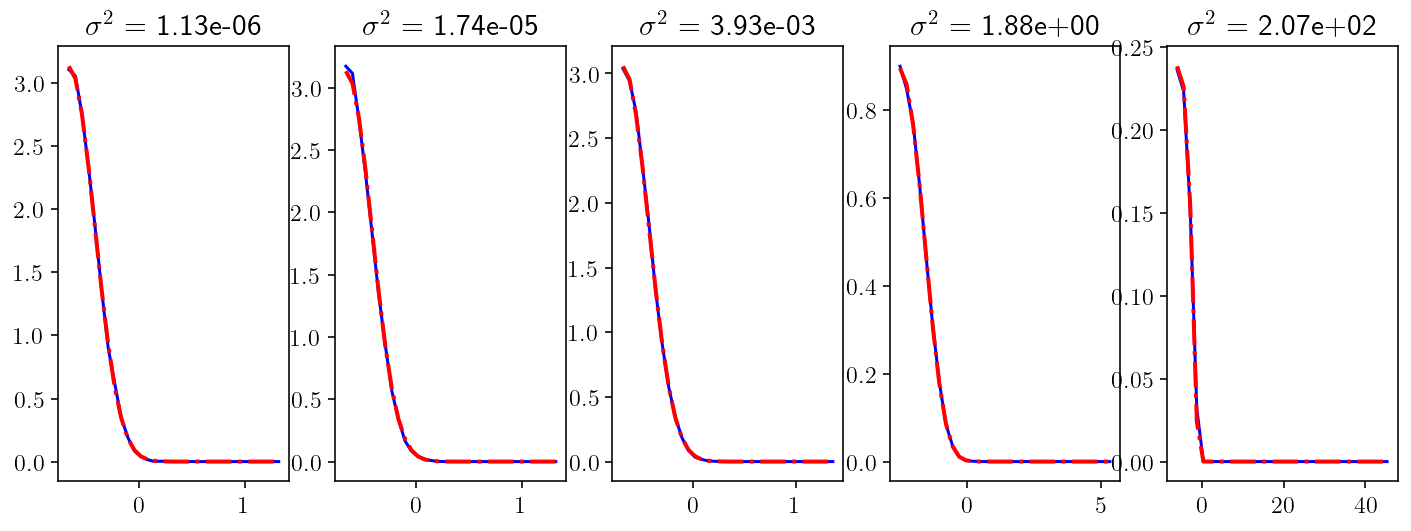

In [12]:
plt.figure(figsize=(12, 4))
for j, sig_idx in enumerate(range(fi.sigma2_n)[::3]):
    mcmc_arm = mcmc_results[sig_idx]["x"][0]["theta"][0, :, arm_idx]
    mcmc_p_ti_g_y = mcmc.calc_pdf(mcmc_arm, cx_all[:, 0, sig_idx], wts[:, 0, sig_idx])

    plt.subplot(1, 5, 1 + j)
    plt.title(f"$\sigma^2$ = {fi.sigma2_rule.pts[sig_idx]:5.2e}")
    plt.plot(cx_all[:, 0, sig_idx], mcmc_p_ti_g_y, "b-")
    # plt.plot(t_i.pts, arm_marg[:, 0, sig_idx], 'r-.', linewidth=2.0)
    plt.plot(cx_all[:, 0, sig_idx], arm_marg[:, 0, sig_idx], "r-.", linewidth=2.0)
plt.show()


## pre-specified fixed quad rule.

this is slow and silly, but works.

In [94]:
arm_idx = 0
t_i = util.simpson_rule(101, -15, 2)
p_pinned = dict(sig2=fi.sigma2_rule.pts, theta=None)
cond_inla_f = inlaw.inla.build_conditional_inla(fl.log_joint_single, fl.spec)
cx = np.tile(t_i.pts[:, None, None], (1, x_max.shape[0], x_max.shape[1]))
lp = cond_inla_f(x_max, p_pinned, data, hess, cx, arm_idx)
arm_marg = inlaw.inla.exp_density(lp, t_i.wts[:, None, None], axis=0)


(101, 1, 15) (101, 1, 1)


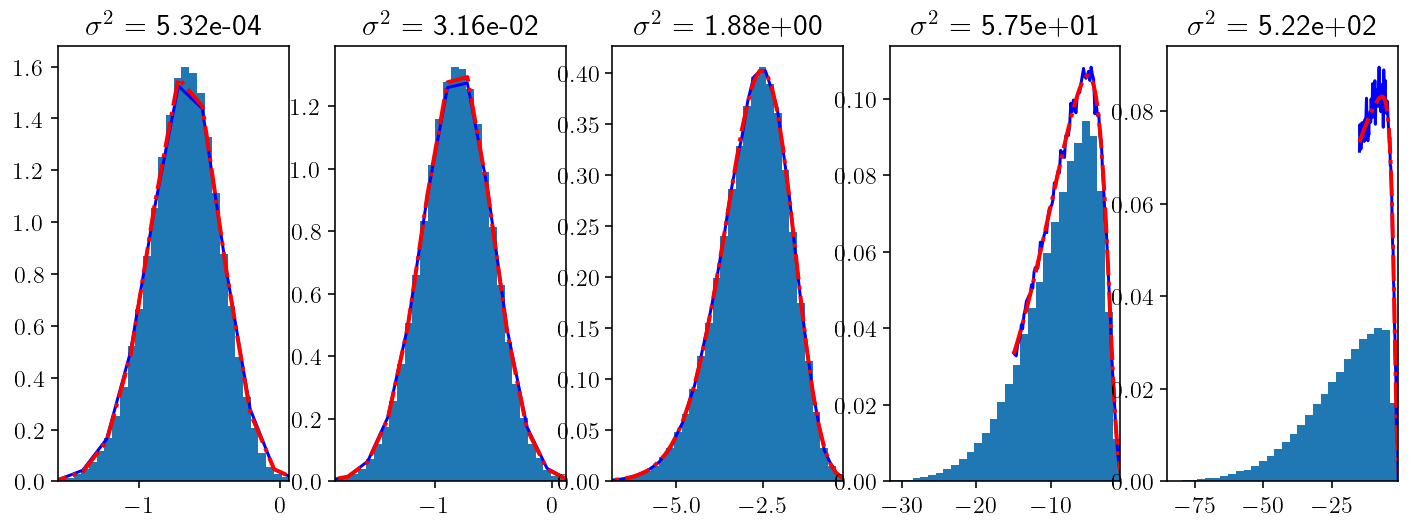

In [96]:
plt.figure(figsize=(12, 4))
for j, sig_idx in enumerate(range(fi.sigma2_n)[5::2]):
    mcmc_arm = mcmc_results[sig_idx]["x"][0]["theta"][0, :, arm_idx]
    mcmc_p_ti_g_y = mcmc.calc_pdf(mcmc_arm, t_i.pts, t_i.wts)

    plt.subplot(1, 5, 1 + j)
    plt.title(f"$\sigma^2$ = {fi.sigma2_rule.pts[sig_idx]:5.2e}")
    plt.plot(t_i.pts, mcmc_p_ti_g_y, "b-")
    plt.plot(t_i.pts, arm_marg[:, 0, sig_idx], "r-.", linewidth=2.0)
    window = np.quantile(mcmc_arm, [0.0005, 0.9995])
    plt.hist(mcmc_arm, bins=np.linspace(*window, 31), density=True)
    plt.xlim(*window)
plt.show()


(25, 1, 15)

## Jensen-Shannon divergence

[Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen–Shannon_divergence)

https://stats.stackexchange.com/questions/6907/an-adaptation-of-the-kullback-leibler-distance/6937#6937


The symmetric KL divergence doesn't behave well when there are zeros in either distribution. The JS divergence solves this issue by comparing to the midpoint distribution.

More generally, the issue we are faced with is computing a norm of distributions. so something like the L2 norm of the difference of the functions would be fine. But the more probabalistic/informational divergence metrics are probably better.

One way we can avoid this entirely is to move to evaluating error in terms of the final output, the exceedance. In many cases, all we are going to care about is the exceedance prob for some threshold. This is a scalar (or vector with multiple arms) and would make error tolerances more concrete and understandable. 

In [87]:
import scipy.special


def js_div(x, y, wts):
    R = 0.5 * (x + y)
    a = np.sum(wts * scipy.special.rel_entr(x, R))
    b = np.sum(wts * scipy.special.rel_entr(y, R))
    return 0.5 * (a + b)


In [106]:
import pandas as pd

df = pd.DataFrame(dict(sig2=fi.sigma2_rule.pts))
df["JS_G_M"] = 0
df["JS_L_M"] = 0
for i, sig_idx in enumerate(range(fi.sigma2_n)):
    mcmc_arm = mcmc_results[sig_idx]["x"][0]["theta"][0, :, arm_idx]
    mcmc_p_ti_g_y = mcmc.calc_pdf(mcmc_arm, t_i.pts, t_i.wts)
    gaussian = scipy.stats.norm.pdf(
        t_i.pts, theta_max[-1, sig_idx, 0], theta_sigma[-1, sig_idx, 0]
    )
    df.at[i, "JS_G_M"] = js_div(mcmc_p_ti_g_y, gaussian, t_i.wts)
    df.at[i, "JS_L_M"] = js_div(mcmc_p_ti_g_y, laplace[sig_idx], t_i.wts)
df


,sig2,JS_G_M,JS_L_M
0,0.000001,0.001329,0.001022
1,0.000002,0.000861,0.001355
2,0.000005,0.001104,0.001107
3,0.000017,0.001770,0.000754
4,0.000085,0.001628,0.000636
5,0.000532,0.001511,0.000792
6,0.003932,0.001354,0.000626
7,0.031623,0.001123,0.000299
8,0.254316,0.002730,0.000050
9,1.877937,0.015512,0.000024


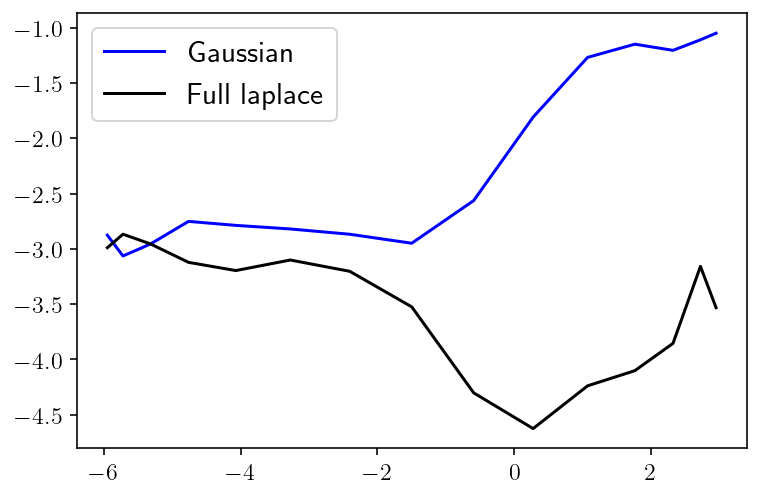

In [111]:
plt.plot(np.log10(df["sig2"]), np.log10(df["JS_G_M"]), "b-", label="Gaussian")
plt.plot(np.log10(df["sig2"]), np.log10(df["JS_L_M"]), "k-", label="Full laplace")
plt.legend()
plt.show()
